## Treemaps  
This lecture is going to be a little bit different because we're going to explore a kind of
visual which matplotlib doesn't have built in support for called the treemap. A tree map is a data
visualization technique that shows hierarchical data as a set of nested rectangles varying in colors and
sizes depending on some data value. So you can see a relationship between two items in the heirarchy through
the rectangles, but you can also see the relationship between values of various components through
coloration, texturing, or the like.

Now, if you google python and treemap you'll see lots of different articles showing you hyow to build a
treemap in python. But they're all wrong as far as I've seen - most of these examples are little more than
square pie charts which show one or more relationships with coloration. Nonetheless, I think it's useful to
see both what treemaps can be, and what we have in python at our disposal to work with. Maybe you or someone
else who sees this video will take up the banner of actually implementing a treemap in python. So, let's
start with the original image of a treemap, from Ben Schneiderman's 1991 technical report where he shared
the original idea. (see http://www.cs.umd.edu/hcil/trs/91-03/91-03.html)

![](assets/tree1.png)

In the top figure we can see the tree data structure he was working with. There are four main nodes, each
containing several leaf nodes. Leaf nodes are all numbered. The figure below, figure 2, shows the whole
tree. Each of the leaf nodes is contiguously connected. For instance, the nodes 6, 8, and 11 appear at the
top, together, and represent one square from the tree diagram. Nodes 5 and 40 are similarly next to one
another, then together those nodes are next to the ones labeled 6, 8, and 11. So the structure of the tree
is represented both explicitly - for the leaf nodes - and implicitly, for the non-leaf nodes.

Now, Ben and his team, as well as other researchers around the world, continued to iterate on the design of
treemaps. Here's another example of a treemap from the early 2000's. (see
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-5-84)

![](assets/ontology.jpg)

This is where things get more interesting! What's particularly important is that now an arbitrary level of
nesting is being shown for the heirarchical data. We see that now binding activity, for instance, contains
both protein binding activity and nucleotide binding activity, and that this latter category includes
several kinds of nucleotide binding activities. Further, this was built into an application which didn't
just show the visualizations but allowed for filtering  of data and exploration of other details of the tree
data structure.

At the same time, I think this image also starts to highlight the problems that treemaps surface -- it's
actually really hard to navigate through deep structures, and when there are many many nodes in the tree
it's difficult to visualize them all and keep the heirarchy clear. For each level in the heirarchy, some
form of border is needed to denote the contains relationship between nodes, which are realized as
rectangles. And this is even more difficult if the nodes are actually supposed to be labeled too, resulting
in clutter when trying to scale.

In [1]:
# So let's see what we can actually do with treemaps in python. There is a library called squarify which helps
# a bit and, perhaps not suprisingly, this library actually emulates a sort of pyplot scripting interface, and
# all of the objects that it creates are actually just matplotlib objects - things like Axes, Figures, and
# Patches. Actually, if you wanted to create your own visualization method and share it with others, this is a
# great way to do it, since the underlying objects are all managed for you. I've linked here to the squarify
# source code, because I think it's actually pretty simple and readable, and demonstrates how you could build
# a library on top of matplot lib that interacts cleanly with the Jupyter notebooks. And who knows, maybe one
# of you will decide to improve the python infoviz ecosystem by forking squarify and adding to heirarchical
# features! https://github.com/laserson/squarify/blob/master/squarify/__init__.py

# Let's bring in our regular imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# And let's bring in the squarify library too
import squarify

# Let's take a look at the squarify plot() function
squarify.plot?

Signature:
squarify.plot(
    sizes,
    norm_x=100,
    norm_y=100,
    color=None,
    label=None,
    value=None,
    ax=None,
    pad=False,
    bar_kwargs=None,
    text_kwargs=None,
    **kwargs,
)
Docstring:
Plotting with Matplotlib.

Parameters
----------
sizes
    input for squarify
norm_x, norm_y
    x and y values for normalization
color
    color string or list-like (see Matplotlib documentation for details)
label
    list-like used as label text
value
    list-like used as value text (in most cases identical with sizes argument)
ax
    Matplotlib Axes instance
pad
    draw rectangles with a small gap between them
bar_kwargs : dict
    keyword arguments passed to matplotlib.Axes.bar
text_kwargs : dict
    keyword arguments passed to matplotlib.Axes.text
**kwargs
    Any additional kwargs are merged into `bar_kwargs`. Explicitly provided
    kwargs here will take precedence.

Returns
-------
matplotlib.axes.Axes
    Matplotlib Axes
File:      /opt/conda/lib/python3.7/site-pa

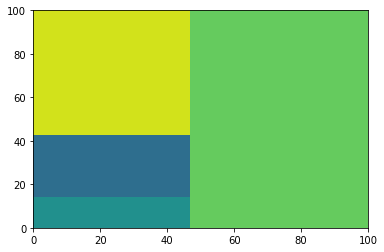

In [2]:
# We see that squarify takes in a list of numeric values which are the squares we want to create. In addition,
# there are a bunch of other parameters we can pass in, including an axes object to plot to a specific axes
# or colors and labels. Let's start with just a trivial example

# Let's plot some powers of two
squarify.plot([2,4,8,16])

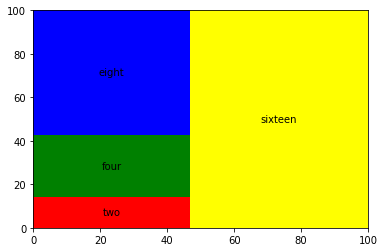

In [3]:
# Now, the colors here are automatically picked for us, and frankly, kind of gross. But we can add colors as
# well if we want to. And we can setup some labels. So let's take a look are a quick round two
squarify.plot([2,4,8,16], label=["two","four","eight","sixteen"], color=["red","green","blue","yellow"])

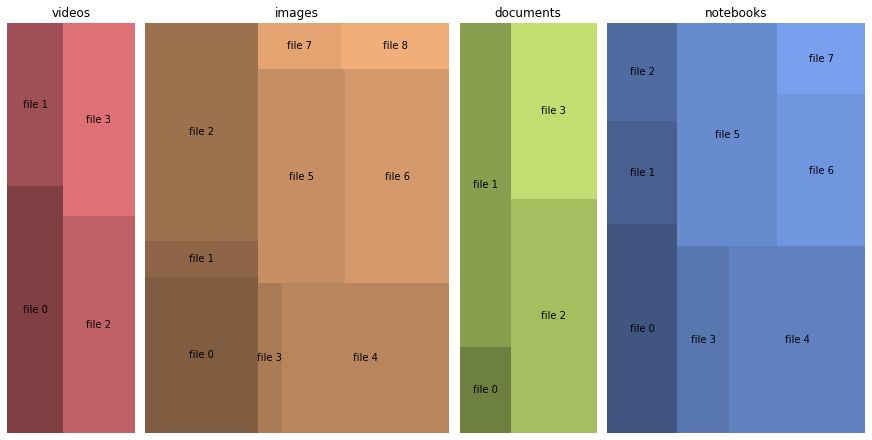

In [4]:
# Well, I didn't really fix the garish colors, but at least I made them predictable :)

# We can see that in python with squarify we really only have a couple of dimensions of data to show, the size
# in area of the squares and the color which might represent some value of interest. And unfortunatly, that's
# about as far as we can go with treemaps in python, at least as far as I know of.

# And actually, this really annoyed me while writing up this lecture. Seeing page after page of google search
# results suggesting that these rectangular pie charts are tree maps. But there's no heirarchy! So, I sat
# back and decided instead of waiting for the world to solve my problem for me, I would take a shot myself.

# Let's go!
# First, let's bring in random and numpy, we'll need them
import random
import numpy as np

# Now let's hack something together. For instance, let's say we had some arbitrary number of directories
directories={"videos":{},"images":{},"documents":{},"notebooks":{}}
# And that each of those directories has a few files in them and those files are some size
for key in directories.keys():
    directories[key]={"file {}".format(i):random.randint(20,1000) for i in range(random.randint(2,10))}

# Now let's measure how big each folder is
directory_sizes={}
for key in directories.keys():
    directory_sizes[key]=np.sum(list(directories[key].values()))

# Now let's generate a bunch of colors for each of the files, which should be similar within a directory
import colorsys
directory_colors={}

def get_colors(n,h):
    '''
    n is the number of colors to return, taken from Sverre Rabbelier at:
    https://stackoverflow.com/questions/876853/generating-color-ranges-in-python
    '''
    HSV_tuples = [(h, 0.5, (x*0.5/n)+0.5) for x in range(n)]
    RGB_tuples = [colorsys.hsv_to_rgb(*x) for x in HSV_tuples]
    return tuple(RGB_tuples)

for key in directories.keys():
    directory_colors[key]=get_colors(len(directories[key].values()), h=random.random())

# Ok, we have our directories listed in the directories dictionary, with their child files. And we now have
# top level information in the directory_sizes() and directory_colors() dictionarys. Now my strategy is to
# generate a new Axes object for each directory, and scale the size of the Axes object to the size of the
# directory. We can do this with the GridSpec functionality in matplotlib. This essentially allows us more
# fine grained control over our figure subplots, changing the relative size of each Axes. In this case we
# will change sizes of the Axes in width based on the size of the files in a directory.
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = GridSpec(1, len(directories), figure=fig, width_ratios=list(directory_sizes.values()))

# The way I've set this up is a significant limitation, as I've decided that I'll only have one row, and that
# each Axes will be lined up and chopped up based on its size in that row. This doesn't scale well, and sort
# of creates a "strip" plot, which reads as left to right, but it should be sufficient to demo

# Now I want to create a list of Axes objects, each associated with one Directory
directories_axes=[]
for i in range(len(directories)):
    # I'll add to this list the results of add_subplot(), calling in our gridspec. That will help matplotlib
    # create the Axes and associate it with the figure
    directories_axes.append(fig.add_subplot(gs[i]))

# Now we just iterate over ever item in the director
for i in range(len(directories)):
    dir_name=list(directories.keys())[i]
    # And we plot that item with squarify, passing in our particulars and directing squarify to render to
    # the given Axes objects we created with gridspec
    squarify.plot(list(directories[dir_name].values()), label=list(directories[dir_name].keys()), 
                  ax=directories_axes[i], color=directory_colors[dir_name])
    # And we'll set the name of the axes and hide the axis details to make it a bit more readable
    directories_axes[i].set_title(dir_name)
    directories_axes[i].set_axis_off()

Now that looks a lot like a Tree Map! Sure, it took me 70 lines of code to write it and hours digging
through how squarify worked as well as learning more about color spaces than I wanted to. And yes, this is a
pretty limited looking tree map - it's one big strip and we haven't rendered everything that might be
useful. I also carefully crafted some of the defaults to ensure the code would work but that there weren't
too many files which would make it unreadable. But hopefully you see the two points of this lecture. First,
a tree map as an exploratory technique has a lot of power in that you can represent heirarchy and two other
variables - color saturation in this case and size of a file - all at once. But that the tree map does
suffer from some usability issues as it scales, which we saw in Ben's nucleotide example. But the second
second lesson is that, with a knowledge of matplotlib and a determination to dig deeper, you can start to
create your own visualizations which are tied to your needs and your data. And who knows, maybe you want to
fork squarify and turn it into a real treemap library, I think that would be great!